# Get data

In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 146kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains 'flow_files_raft_anon003.zip'"}).GetList()
for flow_file in listed:
  print('title {}, id {}'.format(flow_file['title'], flow_file['id']))

listed = drive.ListFile({'q': "title contains 'masks.zip'"}).GetList()
for mask_file in listed:
  print('title {}, id {}'.format(mask_file['title'], mask_file['id']))

listed = drive.ListFile({'q': "title contains 'anon003.zip'"}).GetList()
for video_file in listed:
  print('title {}, id {}'.format(video_file['title'], video_file['id']))

# scripts
listed = drive.ListFile({'q': "title contains 'scripts.zip'"}).GetList()
for scripts in listed:
  print('title {}, id {}'.format(scripts['title'], scripts['id']))

title flow_files_raft_anon003.zip, id 1R2KUDDY-Qpm3HPkn-2qjtS4d_6sR8HLC
title masks.zip, id 1lBgLfSBD_8d0PxBSEI9uP7W3o-8bnZzW
title anon003.zip, id 1m9ITnMoh-CA6PDlYt0oBT9r2y24Q6l_B
title scripts.zip, id 1Nh2P7L_-b7RwY-WNg1op894T3GFdWBEQ


In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = flow_file['id']

fname = os.path.join('/content', 'flow_files.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)

file_id = mask_file['id']

fname = os.path.join('/content', 'masks.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)


file_id = video_file['id']

fname = os.path.join('/content', 'video.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)


file_id = scripts['id']

fname = os.path.join('/content', 'scripts.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)

downloading to /content/flow_files.zip
downloading to /content/masks.zip
downloading to /content/video.zip
downloading to /content/scripts.zip


In [4]:
!unzip flow_files.zip
!unzip masks.zip
!unzip video.zip
!unzip scripts.zip

Archive:  flow_files.zip
   creating: flow_files_raft_anon003/
  inflating: flow_files_raft_anon003/anon003_12651.flo  
  inflating: flow_files_raft_anon003/anon003_12652.flo  
  inflating: flow_files_raft_anon003/anon003_12653.flo  
  inflating: flow_files_raft_anon003/anon003_12654.flo  
  inflating: flow_files_raft_anon003/anon003_12655.flo  
  inflating: flow_files_raft_anon003/anon003_12656.flo  
  inflating: flow_files_raft_anon003/anon003_12657.flo  
  inflating: flow_files_raft_anon003/anon003_12658.flo  
  inflating: flow_files_raft_anon003/anon003_12659.flo  
  inflating: flow_files_raft_anon003/anon003_12660.flo  
  inflating: flow_files_raft_anon003/anon003_12661.flo  
  inflating: flow_files_raft_anon003/anon003_12662.flo  
  inflating: flow_files_raft_anon003/anon003_12663.flo  
  inflating: flow_files_raft_anon003/anon003_12664.flo  
  inflating: flow_files_raft_anon003/anon003_12665.flo  
  inflating: flow_files_raft_anon003/anon003_12666.flo  
  inflating: flow_files_r

# Get H_array

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import sys
from PIL import Image
from pathlib import Path
from os import listdir
from scipy import optimize
import os
import shutil

In [8]:
import scripts.flow_file_processing as fp
import scripts.registration_processing as rp
import scripts.visualize as vis
import scripts.transformation_processing as tp
import scripts.ssim_processing as sp
import scripts.utility_processing as up
import scripts.config_project as config_project

## Resize images

In [17]:
# IMG_SHAPE_STANDARD = (448,448); #does not need an image standard as it gives in full size
seq_name = "anon003"
frames_path = "/content/" + seq_name
fullImgDirPath = "/content/" + seq_name
flowFileDirPath = "/content/flow_files_raft_" + seq_name + "/"
transformation = "Affine"
mask_path = '/content/masks/' + seq_name + '_mask.png'
padding_size = 2500
is_exact = False
showImages = False
threshold = 7

if is_exact:
  seq_config = config_project.seq_exact 
else:
  seq_config = config_project.seq_extra

In [18]:
seq_config

{'anon001': {'file_length': 400,
  'name': 'anon001',
  'start': 20,
  'v_crop_bottom': 0,
  'v_crop_top': 0},
 'anon002': {'file_length': 300,
  'name': 'anon002',
  'start': 120,
  'v_crop_bottom': 0,
  'v_crop_top': 0},
 'anon003': {'file_length': 150,
  'name': 'anon003',
  'start': 10,
  'v_crop_bottom': 0,
  'v_crop_top': 0},
 'anon005': {'file_length': 200,
  'name': 'anon005',
  'start': 20,
  'v_crop_bottom': 20,
  'v_crop_top': 60},
 'anon010': {'file_length': 200,
  'name': 'anon010',
  'start': 70,
  'v_crop_bottom': 70,
  'v_crop_top': 80},
 'anon012': {'file_length': 200,
  'name': 'anon006',
  'start': 81,
  'v_crop_bottom': 70,
  'v_crop_top': 80}}

In [12]:
# A straight replacement in same folder is what I want
# def resize_all_images(fullImgDirPath, f):
#   dirs = os.listdir(path)
#   for item in dirs:
#       if item.lower().endswith(('.png', '.jpg', '.jpeg')):
#         im = Image.open(os.path.join(path,item))
#         imResize = im.resize(IMG_SHAPE_STANDARD, Image.ANTIALIAS)
#         imResize.save(os.path.join(path,item), 'PNG')

# up.resize_all_images(fullImgDirPath, fullImgDirPath, IMG_SHAPE_STANDARD)

In [19]:
flowPaths =  [ flowFileDirPath + '/' + f  for f  in sorted(listdir(flowFileDirPath))]
fullImgPaths =  [ fullImgDirPath + '/' + f  for f  in sorted(listdir(fullImgDirPath))]

In [21]:
# confirm size
a = cv2.imread(fullImgPaths[0])
a.shape

(550, 550, 3)

In [22]:
v_crop_top = seq_config[seq_name]["v_crop_top"]
v_crop_bottom = seq_config[seq_name]["v_crop_bottom"]

mask_im = fp.get_mask_im(fullImgPaths, mask_path, v_crop_top, v_crop_bottom)

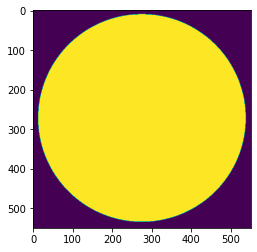

In [23]:
vis.visualizeImg(mask_im)

In [24]:
fullImgPaths = config_project.get_img_paths(fullImgPaths, seq_name, is_exact)

In [25]:
seq_length = seq_config[seq_name]["file_length"] 
seq_length

150

### Get H

In [26]:
padding = padding_size
threshold = 7
if transformation == "Homography":
  H_array = np.zeros((seq_length, 3,3 ))
elif transformation == "Affine":    
  H_array = np.zeros((seq_length, 2,3 ))
showImages = False

In [27]:
for i in range(seq_length): #
  if i == 0:
    H_array[i] = np.concatenate([np.eye(2), np.array([[0],[0]])] ,axis=1)
  else:
    destImgPath = fullImgPaths[i-1] #the previous image
    srcImgPath =  fullImgPaths[i];
    flowPath = flowPaths[i-1]

    srcImg, destImg = fp.inputAndVisualizeStitchPair(srcImgPath, destImgPath, showImages)
    flow = fp.inputAndFormatFlowfile(flowPath)
    I, J = fp.getCameraPixels(destImg, mask_im)
    # middle image -> image
    ptsA, ptsB = fp.pointCorrespondenceFromOpticalFlow(flow, 0 ,I, J)
    H, status = fp.findTransformation(ptsA, ptsB,transformation, threshold)
    H_array[i] = H

tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 552 height 552
(552, 552, 2)
tag 202021.25 width 

In [28]:
H_array.shape

(150, 2, 3)

## Get H_global

In [29]:
### Select a value that is close to the middle, but divisible by 3 
middle_num = len(fullImgPaths)//2
middle_num = middle_num
middle_num

75

In [ ]:
# H_array[0] = np.concatenate([np.eye(2), np.array([[0],[0]])] ,axis=1)

In [30]:
print(H_array[0])
print(H_array[middle_num])

[[1. 0. 0.]
 [0. 1. 0.]]
[[ 0.98276655 -0.0262899   5.86257444]
 [ 0.00755241  1.0073492  -1.84936346]]


In [31]:
H_global = rp.getHGlobal(H_array, fullImgPaths, middle_num)

In [32]:
H_global[middle_num]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [33]:
H_global.shape

(150, 3, 3)

Try and join them together, use alpha channel, to make them transparent a bit then overlap

In [34]:
!mkdir globalRegistrationTransparent

In [ ]:
# import shutil
# shutil.rmtree('/content/globalRegistrationTransparent')

In [35]:
def globalRegistration(img, imageName, index, padding, mask_im):
    ht, wd, cc= img.shape

    ww = wd + (2*padding)
    hh = ht + (2*padding)

    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    color = (0,0,0)

    img = cv2.bitwise_and(img, img, mask=mask_im)
    
    # vis.visualizeImg(img)

    T = np.copy(H_global[index])

    T[:2, 2] = T[:2, 2] + [xx , yy] 
    # print(T)

    result = cv2.warpPerspective(img, T, (ww, hh))

    # vis.visualizeImg(result)

    return result

In [36]:
def do_global_registration(fullImgPaths, middle_num):
    for i in range(len(fullImgPaths)):
        imgPath = fullImgPaths[i];
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
        imageName = Path(fullImgPaths[i]).name

        src = globalRegistration(img, imageName, i, padding_size, mask_im)
        rp.getTransparentImg(src, imageName)

In [37]:
do_global_registration(fullImgPaths, middle_num)

In [38]:
!zip -r /content/globalRegistration.zip /content/globalRegistrationTransparent

  adding: content/globalRegistrationTransparent/ (stored 0%)
  adding: content/globalRegistrationTransparent/anon003_12787.png (deflated 30%)
  adding: content/globalRegistrationTransparent/anon003_12701.png (deflated 36%)
  adding: content/globalRegistrationTransparent/anon003_12802.png (deflated 27%)
  adding: content/globalRegistrationTransparent/anon003_12784.png (deflated 29%)
  adding: content/globalRegistrationTransparent/anon003_12728.png (deflated 33%)
  adding: content/globalRegistrationTransparent/anon003_12743.png (deflated 34%)
  adding: content/globalRegistrationTransparent/anon003_12782.png (deflated 29%)
  adding: content/globalRegistrationTransparent/anon003_12673.png (deflated 38%)
  adding: content/globalRegistrationTransparent/anon003_12749.png (deflated 32%)
  adding: content/globalRegistrationTransparent/anon003_12670.png (deflated 37%)
  adding: content/globalRegistrationTransparent/anon003_12661.png (deflated 37%)
  adding: content/globalRegistrationTransparent/

In [ ]:
2+2

4

In [ ]:
# import shutil
# shutil.rmtree('/content/globalRegistrationTransparent')